In [1]:
import sys
sys.path.insert(0, '../')
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st
from util import optimiser
from util import distribution

import pandas as pd
import seaborn as sns

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.



Demiguel Nogalwes 2009 ran a model as follows:

they assume the true asset-return distribution is given as $$\mathbf{X} = 99\% \times \mathcal{N}(\mu,\Sigma) + 1\% \times D $$
where $D = \mathcal{N}(\mu_d,\Sigma_d)$ where $\Sigma_d=\Sigma$

Lim et al used the follow model:
$$ \mathbf{X} \sim \mathcal{N}(\mathbf{\mu},\mathbf{\Sigma})$$


In our scenario, we assume the stocks are generated from a multivariate T distribution
$$ \mathbf{X} \sim \mathcal{t}_{\nu}(\mathbf{\mu},\mathbf{\Sigma})$$
</p>Given $N$ risky assets the mean variance portfolio is the solution to the problem 
$$\min_w \mathbf{w}^T\hat{\Sigma}\mathbf{w} - \frac{1}{\gamma}\hat{\mathbf{\mu}}^T\mathbf{w}$$ 
$$s.t. \mathbf{w}^T\mathbf{e} = 1 $$</p>

<p> We also seek to find the minimum-variance porfolio 
    $$\min_w \mathbf{w}^T\hat{\Sigma}\mathbf{w}$$
    $$s.t. \mathbf{w}^T\mathbf{e} = 1 $$</p>

In [2]:
# this is the mean and covariance of the multivariate distribution
mu = np.array([26.11 , 25.21 , 28.90 , 28.68 , 24.18])
covar = np.array([[3.715 , 3.730 , 4.420 , 3.606 , 3.673],
                 [3.730 , 3.908 , 4.943 , 3.732 , 3.916],
                [4.420 , 4.943 , 8.885 , 4.378 , 5.010],
                  [3.606 , 3.732 , 4.378 , 3.930 , 3.789],
                  [3.673 , 3.916 , 5.010 , 3.789 , 4.027]])
model = st.multivariate_normal(mean=mu,cov=covar)
#model = distribution.Multivariate_T(mu,covar,3.5)

In [3]:
def mean_variance(weights,mean,cov,gamma,average=False):
    var = np.dot(np.dot(weights,cov),weights)
    mean = 1.0/gamma*np.dot(mean,weights)
    if average:
        return np.mean(var-mean,axis=0)
    else: 
        return var-mean

In [4]:
def compute_mean_variance(samples,values=()):
    if not values:
        mean = np.mean(samples,axis=0)
        cov = np.cov(samples.T)
        return (mean,cov)
    else:
        return values

In [5]:
def sum_weights(weights):
    return np.sum(weights)-1

In [6]:
def fix_string(x):
    return np.array([float(z) for z in x[1:-1].split(' ') if z is not ""])

In [10]:
init_weights = np.ones((5))/5
gamma = [20]
N = [20,50,100,200]
constraints = [{'type':'eq','fun':sum_weights}]
try:
    df = pd.read_csv('portfolio_opt.csv',index_col=0)
    df['w_star'] = df['w_star'].apply(lambda x:fix_string(x))
except:
    df = pd.DataFrame(columns=['w_star','method','gamma','N'])

In [11]:
n_iter = 500

In [12]:
N = [50,100,200]

In [14]:
saa = optimiser.SAA(objective_function=mean_variance,
                    constraints=constraints,
                    bounds=[(0,None)]*5,
                   helper_func=compute_mean_variance)
bagger = optimiser.BaggingSolver(iterations=200,
                                 objective_function=mean_variance,
                                constraints=constraints,
                                 bounds=[(0,None)]*5,
                                helper_func=compute_mean_variance)
mle = optimiser.MLESolver(distribution.Multivariate_T,
                         objective_function=mean_variance,
                                constraints=constraints,
                                 bounds=[(0,None)]*5,
                                helper_func=compute_mean_variance)

In [15]:
methods = [saa,bagger,mle]

In [16]:
for j in range(len(gamma)):
    for l in range(n_iter):
        for i in range(len(N)):
            samples = model.rvs(N[i])
            for ele in methods:
            
                w_star = ele.solve(samples,init_weights,additional_args=(gamma[j],False))   
                results = {'w_star': w_star,'method':ele.__str__(),'gamma':gamma[j],'N':N[i]}
                df = df.append(results,ignore_index=True)
            
    w_star = ele.solve(samples,
                       init_weights,
                       additional_args=(gamma[j],False),
                       values=(mu,covar))         
    results = {'w_star': w_star,'method':'True','gamma':gamma[j],'N':N[i]}
    df = df.append(results,ignore_index=True)

In [17]:
df['expected_return'] = df['w_star'].apply(lambda x:np.dot(mu,x))
df['mean_variance'] = df.apply(
                        lambda x:mean_variance(
                            x['w_star'],
                            mu,
                            covar,
                            x['gamma']),
                        axis=1)

For MLE of the multivariate T, the EM algorithm is used for fixed degree of freedom
https://niasra.uow.edu.au/content/groups/public/@web/@inf/@math/documents/mm/uow236236.pdf

/home/harrison/.virtualenvs/python3/lib/python3.5/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5, 1.0, 'Gamma = 20')

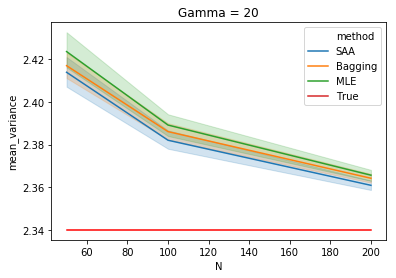

In [18]:
gamma_df = df[df['gamma']==20.0]
ax = sns.lineplot(x=gamma_df['N'], y=gamma_df['mean_variance'], 
                  hue=gamma_df['method'])
plt.plot(N,[gamma_df[gamma_df['method']=='True']['mean_variance'].iloc[0]]*len(N),color='red')
plt.title("Gamma = 20")

In [ ]:
df.to_csv("normal_dist_portfolio_opt.csv")